
# Which user groups perform what action
To find which user segments (e.g., male vs female, age groups, hometowns) are more likely to perform certain actions (like posting content, buying, etc.), you can apply a mix of exploratory data analysis, statistical testing, and predictive modeling.

A comprehensive Python example walking through these steps using a synthetic dataset. It includes:
* Exploratory analysis (group-by & action rates)
* Statistical significance testing (Chi-square for gender & action)
* Predictive modeling (logistic regression + feature importance)
* Interpretation notes and comments at every step

## Imports & Sample Data Creation

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind, fisher_exact
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import statsmodels.api as sm

# Create a synthetic user dataset with demographics and binary action flag
np.random.seed(42)

n = 1000
df = pd.DataFrame({
    'user_id': range(1, n+1),
    'gender': np.random.choice(['Male', 'Female'], n, p=[0.5, 0.5]),
    'age': np.random.randint(18, 60, n),
    'hometown': np.random.choice(['TownA', 'TownB', 'TownC'], n, p=[0.4, 0.35, 0.25]),
})

# Create a binary outcome 'action_flag' influenced by gender and age
# (e.g., females and younger users slightly more likely to perform the action)
df['action_flag'] = np.random.binomial(
    1,
    p=0.1 + 0.1*(df['gender'] == 'Female') + 0.002*(60 - df['age']),
    size=n
)

# Show head of dataset
df.head()

,user_id,gender,age,hometown,action_flag
0,1,Male,29,TownB,0
1,2,Female,33,TownB,1
2,3,Female,41,TownA,0
3,4,Female,36,TownA,0
4,5,Male,25,TownC,0


## Exploratory Analysis: Action Rates by Segment

In [41]:
# Calculate action rate by gender
action_rate_gender = df.groupby('gender')['action_flag'].mean().reset_index()
print("Action Rate by Gender:\n", action_rate_gender)

# Calculate action rate by age groups (create bins)
df['age_group'] = pd.cut(df['age'], bins=[17, 25, 35, 45, 60], labels=['18-25','26-35','36-45','46-60'])
action_rate_age = df.groupby('age_group', observed=False)['action_flag'].mean().reset_index()
print("\nAction Rate by Age Group:\n", action_rate_age)

# Calculate action rate by hometown
action_rate_home = df.groupby('hometown')['action_flag'].mean().reset_index()
print("\nAction Rate by Hometown:\n", action_rate_home)

Action Rate by Gender:
    gender  action_flag
0  Female     0.265594
1    Male     0.139165

Action Rate by Age Group:
   age_group  action_flag
0     18-25     0.239583
1     26-35     0.219124
2     36-45     0.197248
3     46-60     0.171091

Action Rate by Hometown:
   hometown  action_flag
0    TownA     0.190000
1    TownB     0.213675
2    TownC     0.204819


In [42]:
df.head()

,user_id,gender,age,hometown,action_flag,age_group
0,1,Male,29,TownB,0,26-35
1,2,Female,33,TownB,1,26-35
2,3,Female,41,TownA,0,36-45
3,4,Female,36,TownA,0,36-45
4,5,Male,25,TownC,0,18-25


### Interpretation
This gives a first idea where action rates differ. For example, if females show a 20% action rate vs males 10%, that’s a strong signal.

##  Statistical Significance Testing: Gender vs Action

### Contingency table (crosstab)
First, a **contingency table** (also called a **cross-tabulation** or **crosstab**) is used to display the frequency distribution of the two categorical variables (can also be used for more than two in).

* It’s a tool to analyze the relationship between two (or more) categorical variables.
* It shows _how often different combinations of categories occur together_.
* Often used as input for tests like the Chi-Square test of independence.

Since both variables are categorical (gender and binary action), **Chi-square test is the standard** approach to test independence.

In [61]:
# Create contingency table (crosstab is the implementation in pandas)
contingency_table = pd.crosstab(df['gender'], df['action_flag'])
print("\nContingency Table (Gender vs Action):\n", contingency_table)


Contingency Table (Gender vs Action):
 action_flag    0    1
gender               
Female       382  128
Male         419   71


### Chi-Square Test of Independence

Answers the core question:

> “Is there a statistically significant relationship between these categorical variables, beyond what we’d expect by chance?”


* Input:
  * a contingency table (e.g., from pd.crosstab).
* Output:
  * Chi² statistic (how far observed counts deviate from expected counts)
  * p-value (probability of seeing such deviation if variables were independent)
  * degrees of freedom
  * expected counts (what we’d expect if variables were truly independent)

In [ ]:
# Chi-square test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:\nChi2 = {chi2:.3f}, p-value = {p_value:.5f}")

if p_value < 0.05:
    print("=> Reject null hypothesis: Gender and action are statistically dependent.")
else:
    print("=> Fail to reject null hypothesis: No significant dependency found.")

### Deep Dive: Contingency table to check for dependency
A contingency table summarizes the relationship between categorical variables by counting occurrences. It is fundamental in categorical data analysis.
* It summarizes data by **counting how many times different combinations of categories occur**.
* Typically, one categorical variable is displayed along the rows and another along the columns.
* Each cell in the table represents the count (or sometimes proportion) of observations that fall into that combination of categories.


In [56]:
import pandas as pd

# Example data
data = {
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male'],
    'Fruit': ['Apple', 'Banana', 'Apple', 'Orange', 'Banana']
}

df_cont = pd.DataFrame(data)

# Create a contingency table
contingency = pd.crosstab(df_cont['Gender'], df_cont['Fruit'])
print(contingency)

Fruit   Apple  Banana  Orange
Gender                       
Female      0       1       1
Male        2       1       0


### Deep Dive: Chi-square (χ²) test
The Chi-square (χ²) test is a statistical test used to determine whether there is a significant association between two categorical variables.

* You have a contingency table (observed frequencies).
* The Chi-square test compares those observed counts with the expected counts (what you would see if the variables were independent).
* If the difference between observed and expected counts is “too large,” you conclude that the variables are not independent (they’re related).

Forumla:
$\chi^2 = \sum \frac{(O - E)^2}{E}$

* O = observed frequency
* E = expected frequency (calculated assuming independence)

The **sum across all cells gives the Chi-square statistic**, which is compared to a critical value from the Chi-square distribution.

Example in Python:
Suppose we want to test if gender (Male/Female) and purchase (Yes/No) are independent.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Example contingency table (observed frequencies)
# Rows = Gender, Columns = Purchase
data = pd.DataFrame({
    "Yes, purchased": [30, 10],   # purchased
    "No, not purchased":  [20, 40]    # did not purchase
}, index=["Male", "Female"])

print("Contingency Table:")
print(data)

# Run Chi-square test to test independence
chi2, p, dof, expected = chi2_contingency(data)

print("\nChi-square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)
print("\nExpected Frequencies (if independent):")
print(expected)

# Interpret result
alpha = 0.05
if p < alpha:
    print("\nRejected H₀: Gender and Purchase are associated (dependence).")
else:
    print("\nFailed to reject H₀: Gender and Purchase are independent.")

Contingency Table:
        Yes, purchased  No, not purchased
Male                30                 20
Female              10                 40

Chi-square Statistic: 15.041666666666668
Degrees of Freedom: 1
P-value: 0.00010516355403363098

Expected Frequencies (if independent):
[[20. 30.]
 [20. 30.]]

Rejected H₀: Gender and Purchase are associated (dependence).


### Deep Dive: Statistical independence
“See the math” behind the Chi-square test of independence

1. Build the contingency table (observed counts) - from the example:

|Purchase = Yes|Purchase = No|Row Total|
|--------------|-------------|---------|
|Male|30|20|50|
|Female|10|40|50|
|Col|Total|40|60|100|


2. Compute the expected counts if H₀ (independence) is true
$E_{ij} = \frac{(\text{Row Total}_i) \times (\text{Col Total}_j)}{\text{Grand Total}}$

* For Male, Yes: E = $\frac{50 \times 40}{100} = 20$
* For Male, No: E = $\frac{50 \times 60}{100} = 30$
* For Female, Yes: E = $\frac{50 \times 40}{100} = 20$
* For Female, No: E = $\frac{50 \times 60}{100} = 30$

So the expected table looks like:

|Gender|Yes|No|
|------|---|--|
|Male|20|30|
|Female|20|30|

Compare Observed vs Expected:


|Gender|Observed|Expected|
|------|--------|--------|
|Male, Yes|30|20|
|Male, No|20|30|
|Female, Yes|10|20|
|Female, No|40|30|

3. Compute the Chi-square statistic

$\chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$

* Male, Yes: $\frac{(30-20)^2}{20} = \frac{100}{20} = 5$
* Male, No: $\frac{(20-30)^2}{30} = \frac{100}{30} \approx 3.33$
* Female, Yes: $\frac{(10-20)^2}{20} = 5$
* Female, No: $\frac{(40-30)^2}{30} \approx 3.33$


$\chi^2 = 5 + 3.33 + 5 + 3.33 = 16.67$

4. Find the p-value
* Degrees of $freedom = (rows-1) \times (cols-1) = (2-1)(2-1) = 1$
* With χ² = 16.67 and df = 1 → **p < 0.0001**

5. Decision
* Since p < 0.05, reject H₀.
* Conclusion: Gender and Purchase are not independent (they are associated).


### What “independence” means mathematically

Two variables X (Gender) and Y (Purchase) are independent if:

$P(X, Y) = P(X) \times P(Y)$

In words:
👉 The probability of being Male and purchasing is just the product of the marginal probabilities.

Apply that to the table

From the marginals:
* $P(\text{Male}) = 50/100 = 0.5$
* $P(\text{Female}) = 0.5$
* $P(\text{Purchase Yes}) = 40/100 = 0.4$
* $P(\text{Purchase No}) = 0.6$

So under independence:
* $P(\text{Male, Yes}) = 0.5 \times 0.4 = 0.20 → Expected count = 100 \times 0.20 = 20$
* $P(\text{Male, No}) = 0.5 \times 0.6 = 0.30 → Expected count = 30$
* Same for Female: 20 and 30.

That’s why both rows are identical in expectation — because under independence, Gender doesn’t matter: Male and Female are predicted to have the same distribution of purchases.

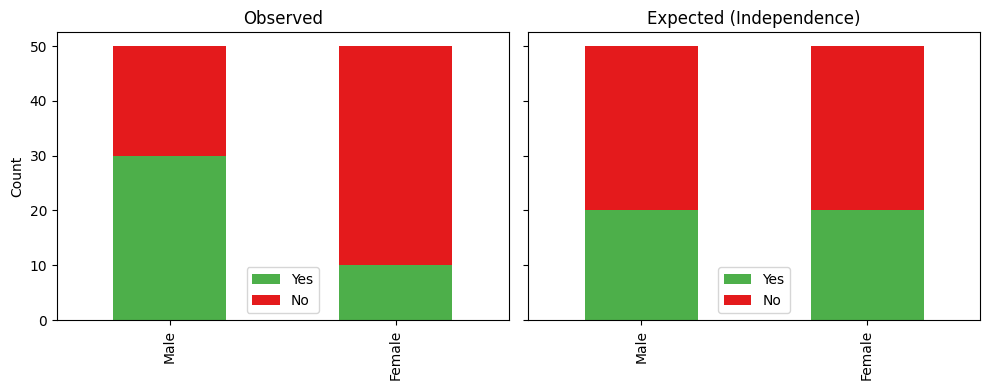

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Observed data
observed = pd.DataFrame({
    "Yes": [30, 10],
    "No": [20, 40]
}, index=["Male", "Female"])

# Expected data under independence
expected = pd.DataFrame({
    "Yes": [20, 20],
    "No": [30, 30]
}, index=["Male", "Female"])

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

observed.plot(kind="bar", stacked=True, ax=axes[0], color=["#4daf4a", "#e41a1c"])
axes[0].set_title("Observed")
axes[0].set_ylabel("Count")

expected.plot(kind="bar", stacked=True, ax=axes[1], color=["#4daf4a", "#e41a1c"])
axes[1].set_title("Expected (Independence)")

plt.tight_layout()
plt.show()

* **Observed**: In reality, Males buy more often (30 yes vs 20 no) while Females buy less (10 yes vs 40 no).
* **Expected (Independence)**: If Gender and Purchase were independent, we’d expect both groups to have the same proportions (40% yes, 60% no → 20/30 in both groups).

### When to use Chi-square, T-test, or Fisher’s Exact Test

| Situation                                     | Recommended Test      | Why?                                 |
|-----------------------------------------------|----------------------|-------------------------------------|
| Two categorical variables (large sample)      | Chi-square test      | Tests independence between categories |
| Binary categorical vs continuous (or interval) | T-test / ANOVA       | Compares means between two or more groups |
| Two categorical variables (small sample or low counts) | Fisher’s Exact Test | Exact test valid for small samples   |

## Predictive Modeling: Logistic Regression (using statsmodels)
We model the probability of the action based on gender, age, and hometown. This gives effect sizes and feature importance.

Note: We use statsmodels here, because scikit-learn is excellent for predictive modeling and production ML pipelines. But here we are interested in finding which segments (gender, age, etc.) are more likely to take an action — **it’s not just about prediction accuracy**, it’s about:

1.	Coefficient estimates with statistical meaning
- statsmodels outputs p-values, confidence intervals, and standard errors for each coefficient.
- This lets you answer: **“Is this variable’s effect statistically significant?” and “How certain is the magnitude?”**
- (scikit-learn’s LogisticRegression doesn’t provide this directly — it focuses on prediction)

2. Clear mapping between variables and coefficients
- The .summary() table in statsmodels shows exactly **which predictors have positive/negative effects and whether they’re significant**.
- It’s closer to what you’d get in R or in academic/statistical software.

3. More statistical model types
- Beyond logistic regression: GLMs, survival models, mixed models, time-series (ARIMA), etc.
- You can use consistent syntax for all.

In [45]:
# Prepare features - encode categorical variables
df_model = df.copy()
# Convert categorical variable into dummy/indicator variables.
df_model = pd.get_dummies(df_model, columns=['gender', 'hometown', 'age_group'], drop_first=True)

# Define X and y
X = df_model.drop(columns=['user_id', 'action_flag'])
y = df_model['action_flag']

# Add intercept for _statsmodels_ logistic regression
# If you don’t add it manually, it will fit a model without one, which often gives biased
# coefficients unless your data is centered.
X_sm = sm.add_constant(X)

# Convert all boolean columns to integers
bool_cols = X_sm.select_dtypes(include=['bool']).columns
X_sm[bool_cols] = X_sm[bool_cols].astype(int)

# Fit logistic regression with statsmodels for interpretability
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.487362
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            action_flag   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      992
Method:                           MLE   Df Model:                            7
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                 0.03140
Time:                        09:19:39   Log-Likelihood:                -487.36
converged:                       True   LL-Null:                       -503.16
Covariance Type:            nonrobust   LLR p-value:                 4.816e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1148      0.603     -0.190      0.849      -1.297       1.068
age           

In [46]:
# Extract significant feature names, excluding 'const' explicitly if present
significant_feats = result.pvalues[result.pvalues < 0.05].index.tolist()

if 'const' in significant_feats:
    significant_feats.remove('const')

print("\nSignificant features:", significant_feats)

# Now select only those features from your original X DataFrame
# YOU COULD use this for building a model using sklearn and use only the significant features
X_selected = X[significant_feats]


Significant features: ['gender_Male']


In [47]:
df_model.head()

,user_id,age,action_flag,gender_Male,hometown_TownB,hometown_TownC,age_group_26-35,age_group_36-45,age_group_46-60
0,1,29,0,True,True,False,True,False,False
1,2,33,1,False,True,False,True,False,False
2,3,41,0,False,False,False,False,True,False
3,4,36,0,False,False,False,False,True,False
4,5,25,0,True,False,True,False,False,False


### Interpretation
* **Coefficients show how each feature increases or decreases the log odds of performing the action.**
* For example, a positive coefficient for gender_Female means females are more likely to perform the action.
* P-values show statistical significance of each predictor.

## Model Evaluation & Feature Importance (scikit-learn)

In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Logistic regression with sklearn
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and classification report
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0)) # zero_division: sklearn throws the warning and sets precision to 0.0 by default.

# Feature importance (coefficients)
feature_importance = pd.Series(clf.coef_[0], index=X.columns).sort_values(ascending=False)
print("\nFeature Importance (logistic regression coefficients):\n", feature_importance)


Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       200
           1       0.00      0.00      0.00        50

    accuracy                           0.80       250
   macro avg       0.40      0.50      0.44       250
weighted avg       0.64      0.80      0.71       250


Feature Importance (logistic regression coefficients):
 hometown_TownB     0.250804
age_group_46-60    0.179527
hometown_TownC     0.167558
age_group_36-45    0.155321
age_group_26-35    0.129470
age               -0.019596
gender_Male       -0.623933
dtype: float64


## Why using statsmodels and logistic regression combined?

| Aspect                     | statsmodels                              | scikit-learn                         |
|----------------------------|-----------------------------------------|------------------------------------|
| **Purpose**                | Statistical inference, interpretability | Predictive modeling, performance   |
| **Output**                 | Coefficients, p-values, confidence intervals | Predictions, accuracy metrics, feature importances (coefficients without p-values) |
| **Use case in your code**  | Understand which variables are significant and their effect sizes | Evaluate model performance on unseen data; make predictions |
| **Model evaluation**       | Doesn’t have built-in train/test splitting or accuracy metrics | Designed for pipeline: split data, train, test, score |
| **Interpretation**         | Easy to communicate statistical significance | Provides classification reports, ROC, etc. for practical performance |


**So why both?**
- **Statsmodels** gives you the “scientific explanation”: Which features truly matter? How confident are we?
- **scikit-learn** gives you the “machine learning practicality”: How well does the model perform on new/unseen data? What’s the precision, recall, F1?

### Typical workflow:
1. **Use statsmodels** for exploratory data analysis, model building, and to check which variables are important and statistically significant.
2.	Once you settle on features, **switch to scikit-learn for building a robust predictive pipeline**, hyperparameter tuning, cross-validation, and performance evaluation.
3.	Use scikit-learn models to generate predictions, score, and integrate into production systems.

# Advanced

## Interaction Terms (Gender × Age)

Adding interaction terms lets you see if the effect of one feature depends on another (e.g., does gender effect vary by age?).

How to do it:
* In logistic regression, add a new feature that’s the product of gender_Female × age (or age_group).
* Check if the interaction coefficient is significant.

In [49]:
df_model.head()

,user_id,age,action_flag,gender_Male,hometown_TownB,hometown_TownC,age_group_26-35,age_group_36-45,age_group_46-60
0,1,29,0,True,True,False,True,False,False
1,2,33,1,False,True,False,True,False,False
2,3,41,0,False,False,False,False,True,False
3,4,36,0,False,False,False,False,True,False
4,5,25,0,True,False,True,False,False,False


In [50]:
# Convert all boolean columns to integers
bool_cols = df_model.select_dtypes(include=['bool']).columns
df_model[bool_cols] = df_model[bool_cols].astype(int)

In [51]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import statsmodels.api as sm
from lifelines import KaplanMeierFitter
from sklift.models import TwoModels

# --------------------
# 1. Synthetic dataset
# --------------------
np.random.seed(42)
n = 1000
df = pd.DataFrame({
    'user_id': range(1, n+1),
    'gender': np.random.choice(['Male', 'Female'], n),
    'age': np.random.randint(18, 60, n),
    'hometown': np.random.choice(['TownA', 'TownB', 'TownC'], n),
})

# Action flag influenced by gender & age
df['action_flag'] = np.random.binomial(
    1,
    p=0.1 + 0.1*(df['gender'] == 'Female') + 0.002*(60 - df['age']),
    size=n
)

# -------------------------
# Add signup/action dates
# -------------------------
df['signup_date'] = pd.Timestamp('2023-01-01') + pd.to_timedelta(
    np.random.randint(0, 30, n), unit='D'
)

# Action date: only for those with action_flag=1, else NaT
df['action_date'] = pd.NaT
mask = df['action_flag'] == 1
df.loc[mask, 'action_date'] = df.loc[mask, 'signup_date'] + pd.to_timedelta(
    np.random.randint(1, 60, mask.sum()), unit='D'
)

## Interaction

**What is it?**
An interaction term in regression models **captures the effect of two or more features working together on the outcome** — beyond their individual effects.
Instead of assuming each variable affects the outcome independently and additively, an interaction term tests if the effect of one variable depends on the level of another.

**Example:**
The effect of gender on buying behavior might be different for different age groups. So you include a term gender × age to capture that nuance.

**When to use it?**
- When you suspect that the impact of one feature varies depending on another.
- To capture complex relationships that simple additive models miss.
- When domain knowledge suggests variables interact.

**What it does for you:**
- Helps uncover conditional relationships between features and outcome.
- Improves model fit and interpretability if interactions matter.
- Allows more precise targeting (e.g., specific age-gender combos).

In [52]:
# -------------------------
# 2. Interaction term
# -------------------------
df['gender_male'] = (df['gender'] == 'Male').astype(int)
df['interaction_gender_age'] = df['gender_male'] * df['age']

X_inter = df[['gender_male', 'age', 'interaction_gender_age']]
y_inter = df['action_flag']

X_inter = sm.add_constant(X_inter)
logit_inter = sm.Logit(y_inter, X_inter)
result_inter = logit_inter.fit()
print("\n=== Logistic Regression with Interaction Term ===")
print(result_inter.summary())

Optimization terminated successfully.
         Current function value: 0.489510
         Iterations 6

=== Logistic Regression with Interaction Term ===
                           Logit Regression Results                           
Dep. Variable:            action_flag   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Aug 2025   Pseudo R-squ.:                 0.01904
Time:                        09:19:39   Log-Likelihood:                -489.51
converged:                       True   LL-Null:                       -499.01
Covariance Type:            nonrobust   LLR p-value:                 0.0002726
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.8090

## Survival analysis

**What is it?**

Survival analysis **models time until an event happens** — e.g., time to churn, time to first purchase, time to feature adoption.
It deals with censored data (users who haven’t yet taken the event by the observation end).

**When to use it?**
- When you want to **understand how long users take to perform an action or experience an event**.
- When users might not have done the event yet (censoring).
- When comparing time-to-event distributions between groups (e.g., gender, treatment vs control).

**What it does for you:**
- Estimates probabilities of surviving (not acting) past a time point — e.g., 30-day retention rates.
- Enables comparison of time-to-event curves across segments or treatments.
- Can model effects of covariates on timing using Cox proportional hazards or other models.

In [53]:
# -------------------------
# 3. Survival analysis
# -------------------------
df['time_to_action'] = (df['action_date'] - df['signup_date']).dt.days
# Fill NaN with censoring limit (e.g., 60 days)
df['time_to_action'] = df['time_to_action'].fillna(60)
df['event_observed'] = df['action_flag']

kmf = KaplanMeierFitter()
kmf.fit(durations=df['time_to_action'], event_observed=df['event_observed'])
print("\n=== Survival Analysis (first 10 survival probabilities) ===")
print(kmf.survival_function_.head(10))


=== Survival Analysis (first 10 survival probabilities) ===
          KM_estimate
timeline             
0.0             1.000
1.0             0.999
2.0             0.996
3.0             0.994
4.0             0.993
5.0             0.992
7.0             0.990
8.0             0.985
9.0             0.981
10.0            0.978


This output is the **Kaplan–Meier survival curve estimate** showing the probability of not having performed the event (e.g., an action) up to each time point (in days).

| timeline (days) | KM_estimate (survival probability)          | Interpretation                                          |
|-----------------|---------------------------------------------|---------------------------------------------------------|
| 0.0             | 1.000 (or 100%)                             | At day 0, everyone has *not* acted yet (starting point).|
| 1.0             | 0.999 (99.9%)                              | About 99.9% of users haven’t performed the action by day 1.|
| 2.0             | 0.996 (99.6%)                              | About 99.6% haven’t acted by day 2, so 0.4% did act between day 1 and 2.|
| 10.0            | 0.978 (97.8%)                              | By day 10, about 2.2% of users have performed the action.|

## Uplift Modeling

**What is it?**

Uplift modeling **predicts the incremental impact of a treatment or action on individual outcomes**. It’s sometimes called causal modeling or heterogeneous treatment effect modeling.

**When to use it?**
- When you run experiments or campaigns and want to identify who truly benefits from the treatment.
- To target interventions more effectively by focusing on users with positive uplift.
- When you want to maximize ROI by avoiding “spenders” who would buy anyway (no uplift).

**What it does for you:**
- Predicts who will respond positively to treatment vs control.
- Helps avoid wasting resources on “doomed” or “sure thing” customers.
- Enables personalized treatment assignment.

In [54]:
# -------------------------
# 4. Uplift modeling
# -------------------------
# Simulate treatment assignment
df['treatment'] = np.random.binomial(1, 0.5, n)

# For demo: outcome is more likely if treated and female
df['outcome'] = np.random.binomial(
    1,
    0.05 + 0.15*df['treatment'] + 0.10*(df['gender'] == 'Female'),
    size=n
)

X_uplift = pd.get_dummies(df[['gender', 'age', 'hometown']], drop_first=True)
y_uplift = df['outcome']
treatment = df['treatment']

uplift_model = TwoModels(
    estimator_trmnt=LogisticRegression(max_iter=500),
    estimator_ctrl=LogisticRegression(max_iter=500),
    method='vanilla'
)
uplift_model.fit(X_uplift, y_uplift, treatment)

uplift_scores = uplift_model.predict(X_uplift)
print("\n=== Uplift Scores (first 10) ===")
print(uplift_scores[:10])


=== Uplift Scores (first 10) ===
[0.14520826 0.08809447 0.19395015 0.16810701 0.15521849 0.16832896
 0.1283236  0.10356832 0.19814396 0.02370063]


Those uplift scores represent, for each user, the predicted incremental impact (or lift) of the treatment on the likelihood of the desired outcome compared to no treatment.

**What does this imply practically?**
- Higher uplift scores = better candidates for treatment.
- You can prioritize targeting users with the highest uplift to maximize campaign ROI.
- Users with low or negative uplift might be left untreated to save costs or avoid negative effects.

How to use uplift scores?
- Sort users by their uplift score descending.
- Target top X% (depending on budget).
- Monitor real-world results to validate the model’s predictions.

|Score Example | Meaning|
|--------------|--------|
|0.19 (19%)|The model predicts this user is about 19 percentage points more likely to take the action because of the treatment.|
|0.02 (2%)|The treatment might increase the chance by 2 percentage points—small but positive.|
|Negative values (if any)|The treatment might actually decrease the chance for this user (harmful or no effect).|



### Summary:
1. Interaction term → Adds gender × age to the logistic regression model and prints the coefficients.
2.	Survival analysis → Creates fake signup/action dates, computes time_to_action, handles censoring for users without an action, and prints a Kaplan–Meier survival table.
3.	Uplift modeling → Simulates treatment assignment and outcome, fits a treatment/control model, and outputs predicted uplift scores.

| Extension Topic   | Method / Tool                        | Input Data Needed                 | What it Adds                                  |
|-------------------|--------------------------------------|------------------------------------|-----------------------------------------------|
| Interaction Terms | Logistic regression with product terms| User features                      | Detect feature interplay, nuanced segments   |
| Survival Analysis | Kaplan-Meier, Cox model              | Time-to-action + censoring         | Model time dimension of user behavior        |
| Uplift Modeling   | Two-model approach, uplift forests   | Treatment assignment + outcome     | Identify who benefits most from campaigns    |